In [1]:
from IPython.display import clear_output

In [2]:
# echo "Downloading 101_Object_Categories for image notebooks"
# curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
# unzip 101_ObjectCategories.zip
# mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
# tar -xzf 101_ObjectCategories.tar.gz
# rm 101_ObjectCategories.tar.gz
# ls

# clear_output()

In [3]:
import random

import torch
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # hint: Is something missing?
    transforms.ToTensor(),  # hint: Is something missing?
])

image_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\trh00\Documents\ML-projects\101_ObjectCategories', transform=transform)

In [5]:
print(len(image_dataset))

9144


label=0


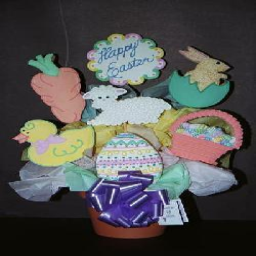

In [6]:
img, label = image_dataset[50]
print(f'{label=}')
transforms.functional.to_pil_image(img)

# Tasks:

1. Download pretrained Resnet18 model from torchhub
2. Modify the model for object 101 dataset subset (The dataset has 101 distinct classes).
3. Split the dataset between training and validation set (80% / 20%).
4. Fine tune the model for classification on the dataset.
5. Output the fine tuned model's overall accuracy on the validation set.
6. Find a way to show label wise performance/accuracy of the finetuned model.

1. Download pretrained Resnet18 model from torchhub
2. Modify the model for object 101 dataset subset (The dataset has 101 distinct classes).


In [13]:
from torchvision.models import resnet18
from torch import nn

model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 102)
print(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
# device = 'cpu'
model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\trh00\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\trh00\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


3. Split the dataset between training and validation set (80% / 20%).


In [14]:
#3. Split the dataset between training and validation set (80% / 20%).
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size

train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

print(len(train_dataset), len(val_dataset))


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


7315 1829


In [15]:
# write code to print all unique labels in the dataset
# labels = set()
# for _, label in image_dataset:
#     labels.add(label)
# print(labels)
# print(len(labels))

4. Fine tune the model for classification on the dataset.
5. Output the fine tuned model's overall accuracy on the validation set.


In [16]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        
        outputs = model(images)  # Forward pass
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


In [17]:
import torch.optim as optim

# Initialize the model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 229/229 [01:06<00:00,  3.45it/s]


Epoch 1/10: Train Loss=1.6905, Train Accuracy=60.85%, Val Loss=1.1146, Val Accuracy=72.44%


100%|██████████| 229/229 [01:04<00:00,  3.55it/s]


Epoch 2/10: Train Loss=0.6520, Train Accuracy=82.60%, Val Loss=0.9832, Val Accuracy=74.85%


100%|██████████| 229/229 [01:05<00:00,  3.52it/s]


Epoch 3/10: Train Loss=0.3372, Train Accuracy=90.59%, Val Loss=0.7490, Val Accuracy=78.79%


100%|██████████| 229/229 [01:04<00:00,  3.56it/s]


Epoch 4/10: Train Loss=0.2041, Train Accuracy=94.18%, Val Loss=0.7852, Val Accuracy=79.50%


100%|██████████| 229/229 [01:04<00:00,  3.57it/s]


Epoch 5/10: Train Loss=0.1381, Train Accuracy=96.06%, Val Loss=0.7011, Val Accuracy=81.79%


 34%|███▍      | 79/229 [00:22<00:42,  3.49it/s]


KeyboardInterrupt: 